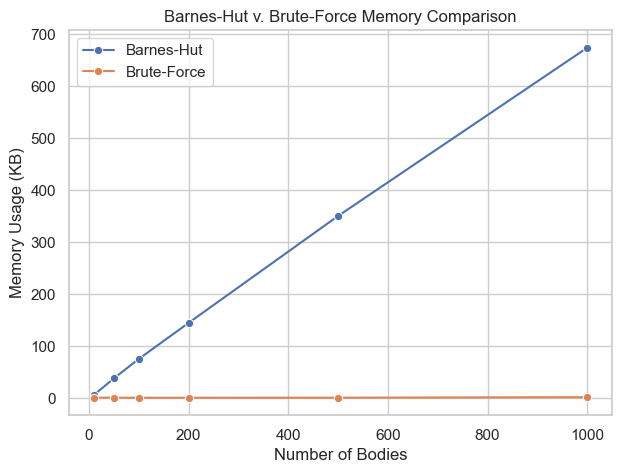

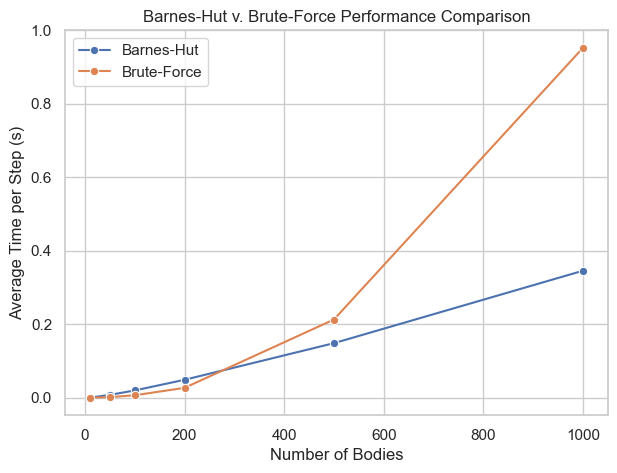

In [26]:
# Simplified Barnes-Hut/brue-force for performance comparison
import numpy as np
import math
import random
import time
import tracemalloc
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
G = 1  # Gravitational constant (larger = stronger attraction)
THETA = 0.5  # Barnes-Hut parameter (larger = faster, but larger error)
DT = 0.1  # Time step (larger = slower, but more precise position incrementation)

class Body:
    def __init__(self, x, y, mass, vx=0, vy=0):
        self.x = x
        self.y = y
        self.mass = mass
        self.vx = vx
        self.vy = vy

    def update_position(self):
        self.x += self.vx * DT
        self.y += self.vy * DT

    def apply_force(self, fx, fy):
        self.vx += fx / self.mass * DT
        self.vy += fy / self.mass * DT

class QuadTreeNode:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.bodies = []
        self.children = []
        self.total_mass = 0
        self.center_of_mass = (0, 0)

    def insert(self, body):
        if not self._contains(body):
            return False

        if len(self.bodies) < 1:
            self.bodies.append(body)
            self._update_mass(body)
            return True

        if not self.children:
            self._subdivide()

        for child in self.children:
            if child.insert(body):
                return True

        return False

    def _contains(self, body):
        return (
            self.x <= body.x < self.x + self.width
            and self.y <= body.y < self.y + self.height
        )

    def _subdivide(self):
        half_width = self.width / 2
        half_height = self.height / 2
        self.children = [
            QuadTreeNode(self.x, self.y, half_width, half_height),
            QuadTreeNode(self.x + half_width, self.y, half_width, half_height),
            QuadTreeNode(self.x, self.y + half_height, half_width, half_height),
            QuadTreeNode(
                self.x + half_width, self.y + half_height, half_width, half_height
            ),
        ]

    def _update_mass(self, body):
        self.total_mass += body.mass
        self.center_of_mass = (
            (
                self.center_of_mass[0] * (self.total_mass - body.mass)
                + body.x * body.mass
            )
            / self.total_mass,
            (
                self.center_of_mass[1] * (self.total_mass - body.mass)
                + body.y * body.mass
            )
            / self.total_mass,
        )

    # Brute-force force calculation
    def compute_force(self, body):
        if not self.bodies:
            return 0, 0

        dx = self.center_of_mass[0] - body.x
        dy = self.center_of_mass[1] - body.y
        distance_sq = dx * dx + dy * dy

        if distance_sq < 1e-10:
            return 0, 0

        if self.width * self.width / distance_sq < THETA * THETA or not self.children:
            force_magnitude = G * self.total_mass * body.mass / distance_sq
            force_x = force_magnitude * dx / math.sqrt(distance_sq)
            force_y = force_magnitude * dy / math.sqrt(distance_sq)
            return force_x, force_y

        force_x, force_y = 0, 0
        for child in self.children:
            fx, fy = child.compute_force(body)
            force_x += fx
            force_y += fy
        return force_x, force_y


# Brute-force force calculation
def brute_force(bodies):
    for i in range(len(bodies)):
        for j in range(len(bodies)):
            if i == j:
                continue
            body1 = bodies[i]
            body2 = bodies[j]

            dx = body2.x - body1.x
            dy = body2.y - body1.y
            distance_sq = dx * dx + dy * dy

            if distance_sq < 1e-10:
                continue

            force_magnitude = G * body1.mass * body2.mass / distance_sq
            force_x = force_magnitude * dx / math.sqrt(distance_sq)
            force_y = force_magnitude * dy / math.sqrt(distance_sq)

            body1.apply_force(force_x, force_y)


# Simulation Functions
# Barnes-Hut
def simulate_barnes_hut(bodies, steps):
    times = []
    tracemalloc.start()  # Start tracking memory usage
    for step in range(steps):
        start_time = time.time()

        root = QuadTreeNode(0, 0, 1000, 1000)
        for body in bodies:
            root.insert(body)

        for body in bodies:
            fx, fy = root.compute_force(body)
            body.apply_force(fx, fy)
            body.update_position()

        times.append(time.time() - start_time)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return times, peak / 1024

# Brute-force
def simulate_brute_force(bodies, steps):
    times = []
    tracemalloc.start()  # Start tracking memory usage
    for step in range(steps):
        start_time = time.time()

        brute_force(bodies)
        for body in bodies:
            body.update_position()

        times.append(time.time() - start_time)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()  # Stop tracking memory usage
    return times, peak / 1024  # Return times and peak memory usage in KB


def main():
    num_bodies = [10, 50, 100, 200, 500, 1000]
    steps = 10

    barnes_hut_times = []
    brute_force_times = []
    memory_usage_bh = []
    memory_usage_bf = []

    for n in num_bodies:
        bodies = [
            Body(random.uniform(0, 1000), random.uniform(0, 1000), random.uniform(1, 10))
            for _ in range(n)
        ]

        # Barnes-Hut
        bh_times, bh_memory = simulate_barnes_hut(bodies, steps)
        barnes_hut_times.append(np.mean(bh_times))
        memory_usage_bh.append(bh_memory)

        # Brute-force
        bf_times, bf_memory = simulate_brute_force(bodies, steps)
        brute_force_times.append(np.mean(bf_times))
        memory_usage_bf.append(bf_memory)

    sns.set(style="whitegrid")

    # Memory usage plot
    plt.figure(figsize=(7, 5))
    sns.lineplot(x=num_bodies, y=memory_usage_bh, label="Barnes-Hut", marker='o')
    sns.lineplot(x=num_bodies, y=memory_usage_bf, label="Brute-Force", marker='o')
    plt.xlabel("Number of Bodies")
    plt.ylabel("Memory Usage (KB)")
    plt.title("Barnes-Hut v. Brute-Force Memory Comparison")
    plt.legend()
    plt.grid(True)
    plt.savefig("memory_usage_comparison.png", bbox_inches='tight', dpi=300)
    plt.show()
    
    # Performance plot
    plt.figure(figsize=(7, 5))
    sns.lineplot(x=num_bodies, y=barnes_hut_times, label="Barnes-Hut", marker='o')
    sns.lineplot(x=num_bodies, y=brute_force_times, label="Brute-Force", marker='o')
    plt.xlabel("Number of Bodies")
    plt.ylabel("Average Time per Step (s)")
    plt.title("Barnes-Hut v. Brute-Force Performance Comparison")
    plt.legend()
    plt.grid(True)
    plt.savefig("performance_comparison.png", bbox_inches='tight', dpi=300)
    plt.show()


if __name__ == "__main__":
    main()